<a href="https://colab.research.google.com/github/wallykop/iad-deep-learning/blob/master/Copy_of_Seminar6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Трюки для обучения нейронных сетей

### **1. Аугментации**

На практике часто оказывается, что нет достаточно большого количества размеченных данных, чтобы адекватно обучить модель, а общедоступные датасеты плохо приближают генеральную совокупность данных, возникающую в реальной задаче.

Однако в таких ситуациях может оказаться полезным изменить объекты из доступной нам выборки. Например, если речь идёт о работе с изображениями, картинки — в зависимости от конкретной задачи — можно поворачивать, искривлять, накладывать дополнительные объекты, добавлять шум, менять яркость, расфокусировать и т. д.

Многие из таких функций реализованы в [preprocessing.image](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image) из TensorFlow.

Возьмём произвольный объект из датасета CIFAR-10:

In [0]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

Using TensorFlow backend.


170500096/170498071 [==============================] - 2s 0us/step


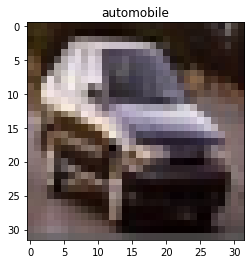

In [0]:
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

rand_index = np.random.randint(0, len(y_train))

x_cur = x_train[rand_index,:]
y_cur = y_train[rand_index, 0]

def draw_image(x, y):
  plt.imshow(x)
  plt.title(cifar10_classes[y])
  plt.show()
  
draw_image(x_cur, y_cur)

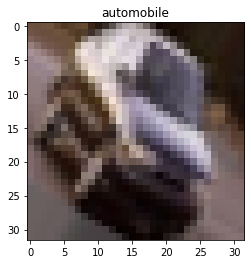

In [0]:
x = tf.keras.preprocessing.image.apply_affine_transform(x_cur, theta=30)
draw_image(x, y_cur)
#Повернём картинку на 30 градусов

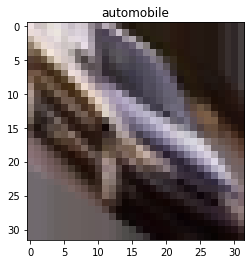

In [0]:
x = tf.keras.preprocessing.image.apply_affine_transform(x_cur, shear=35)
draw_image(x, y_cur)
#Наклоним картинку на 35 градусов

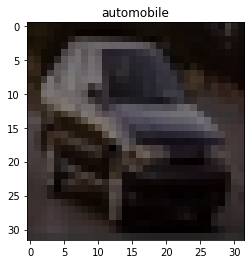

In [0]:
x = tf.keras.preprocessing.image.apply_brightness_shift(x_cur, 0.5)
draw_image(x.astype(int), y_cur)
#уменьшим яркость

Попробуйте реализовать зеркальное отображение картинки относительно вертикальной оси (подсказка: в numpy есть функция для изменения порядка элементов в массиве на обратный по заданному измерению):

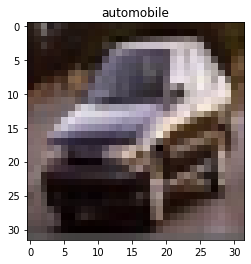

In [0]:
def horizontal_reflect(image):
  return np.flip(image, axis=1)

draw_image(horizontal_reflect(x_cur), y_cur)

Обучим на CIFAR-10 свёрточную нейронную сеть без аугментации (см. семинар 4).

In [0]:
x_train2 = x_train / 255 - 0.5
x_test2 = x_test / 255 - 0.5

y_train2 = tf.keras.utils.to_categorical(y_train, 10)
y_test2 = tf.keras.utils.to_categorical(y_test, 10)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, LeakyReLU

def make_model():
    model = Sequential()
    model.add(Conv2D(filters=16, padding='same', kernel_size=(3,3), input_shape=(32,32,3)))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(filters=32, padding='same', kernel_size=(3,3)))  
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Conv2D(filters=64, padding='same', kernel_size=(3,3)))  
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same')) 
    model.add(Flatten())
    model.add(Dense(256))                
    model.add(LeakyReLU(0.1))
    model.add(Dense(10))             
    model.add(Activation("softmax"))
    
    return model

In [0]:
def reset_tf_session():
    curr_session = tf.get_default_session()
    if curr_session is not None:
        curr_session.close()
    tf.keras.backend.clear_session()
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    tf.keras.backend.set_session(s)
    return s

In [0]:
def train_model(x_train, y_train, x_test, y_test, make_model):
  s = reset_tf_session()
  model = make_model()
  INIT_LR = 5e-3
  BATCH_SIZE = 32
  EPOCHS = 10
  model.compile(
      loss='categorical_crossentropy',
      optimizer=tf.keras.optimizers.Adam(lr=INIT_LR),
      metrics=['accuracy']
  )

  def lr_scheduler(epoch):
      return INIT_LR * 0.9 ** epoch
  
  model.fit(
      x_train, y_train,
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_scheduler)],
      validation_data=(x_test, y_test),
      shuffle=True,
      verbose=1,
      initial_epoch=0
  )
  
train_model(x_train2, y_train2, x_test2, y_test2, make_model)



Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 22s 439us/sample - loss: 1.2798 - acc: 0.5471 - val_loss: 1.0573 - val_acc: 0.6328
Epoch 2/10
50000/50000 [==============================] - 18s 361us/sample - loss: 0.9298 - acc: 0.6783 - val_loss: 0.9271 - val_acc: 0.6879
Epoch 3/10
50000/50000 [==============================] - 18s 359us/sample - loss: 0.7474 - acc: 0.7440 - val_loss: 1.0189 - val_acc: 0.6768
Epoch 4/10
50000/50000 [==============================] - 17s 331us/sample - loss: 0.5885 - acc: 0.7986 - val_loss: 1.0113 - val_acc: 0.7135
Epoch 5/10
50000/50000 [==============================] - 18s 353us/sample - loss: 0.4390 - acc: 0.8496 - val_loss: 1.0840 - val_acc: 0.7116
Epoch 6/10
50000/50000 [==============================] - 18s 365us/sample - loss: 0.3193 - acc: 0.8907 - val_loss: 1.1684 - val_acc: 0.7214
Epoch 7/10
50000/50000 

Добавим аугментацию, используя ImageDataGenerator из preprocessing.image.

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#datagen = ImageDataGenerator(
#    horizontal_flip=True,
#    vertical_flip = True,
#    rotation_range=20,
#		zoom_range=0.15,
#		width_shift_range=0.2,
#		height_shift_range=0.2,
#		shear_range=0.15
#)

datagen = ImageDataGenerator(
    horizontal_flip = True,
    width_shift_range = 0.1,
    vertical_flip = True,
    height_shift_range = 0.1 
)

datagen.fit(x_train2)

BATCH_SIZE = 32

def train_gen_model(train_gen, x_test, y_test, make_model):
  s = reset_tf_session()
  model = make_model()
  INIT_LR = 5e-3
  EPOCHS = 10
  model.compile(
      loss='categorical_crossentropy',
      optimizer=tf.keras.optimizers.Adam(lr=INIT_LR),
      metrics=['accuracy']
  )

  def lr_scheduler(epoch):
      return INIT_LR * 0.9 ** epoch
  
  model.fit_generator(
      train_gen,
      steps_per_epoch = len(x_train) / BATCH_SIZE,
      epochs=EPOCHS,
      callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_scheduler)],
      validation_data=(x_test, y_test),
      shuffle=True,
      verbose=1,
      initial_epoch=0
  )
  
train_gen_model(datagen.flow(x_train2, y_train2, batch_size=BATCH_SIZE), x_test2, y_test2, make_model)



Epoch 1/10
1563/1562 [==============================] - 44s 28ms/step - loss: 1.6028 - acc: 0.4154 - val_loss: 1.3811 - val_acc: 0.5223
Epoch 2/10
1563/1562 [==============================] - 43s 27ms/step - loss: 1.3216 - acc: 0.5284 - val_loss: 1.2374 - val_acc: 0.5754
Epoch 3/10
1563/1562 [==============================] - 43s 27ms/step - loss: 1.2082 - acc: 0.5719 - val_loss: 1.1214 - val_acc: 0.6067
Epoch 4/10
1563/1562 [==============================] - 42s 27ms/step - loss: 1.1251 - acc: 0.6023 - val_loss: 1.0988 - val_acc: 0.6311
Epoch 5/10
1563/1562 [==============================] - 43s 27ms/step - loss: 1.0757 - acc: 0.6214 - val_loss: 1.0668 - val_acc: 0.6392
Epoch 6/10
1563/1562 [==============================] - 42s 27ms/step - loss: 1.0168 - acc: 0.6444 - val_loss: 1.0912 - val_acc: 0.6389
Epoch 7/10
1563/1562 [==============================] - 43s 27ms/step - loss: 0.9733 - acc: 0.6575 - val_loss: 0.9480 - val_acc: 0.6820
Epoch 8/10
1563/1562 [==========================

Обратите внимание, что происходит с loss и accuracy на валидации. Сравните с предыдущим результатом.

### **2. Dropout**



При обучении моделей из предыдущего пункта можно заметить, что после нескольких эпох функция потерь на тестовой выборке начинает расти (при использовании аугментации это происходит позже; как вы думаете, почему?), то есть происходит переобучение. Чтобы избежать этой проблемы, существуют различные методы, например, [Dropout](https://http://jmlr.org/papers/v15/srivastava14a.html).

Идея метода заключается в том, чтобы при обучении случайно исключать из некоторых слоёв часть нейронов. Предполагается, что это уменьшит "совместную адаптацию" (когда одни нейроны обучаются исправлять ошибки других) и позволит избежать переобучения.

Добавим в нашу модель слои Dropout.

In [0]:
def make_dropout_model():
    model = Sequential()
    model.add(Conv2D(filters=16, padding='same', kernel_size=(3,3), input_shape=(32,32,3)))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters=32, padding='same', kernel_size=(3,3)))  
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters=64, padding='same', kernel_size=(3,3)))  
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same')) 
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(256))                
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.2))
    model.add(Dense(10))             
    model.add(Activation("softmax"))
    #YOUR CODE HERE
    #используйте модель из make_model и добавьте между её слоями слои Dropout(p), где p - вероятность исключения одного нейрона
   
    return model
  
train_model(x_train2, y_train2, x_test2, y_test2, make_dropout_model)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 19s 381us/sample - loss: 1.4188 - acc: 0.4991 - val_loss: 1.1267 - val_acc: 0.6214
Epoch 2/10
50000/50000 [==============================] - 19s 376us/sample - loss: 1.1623 - acc: 0.5978 - val_loss: 1.0300 - val_acc: 0.6381
Epoch 3/10
50000/50000 [==============================] - 19s 372us/sample - loss: 1.0527 - acc: 0.6366 - val_loss: 0.9514 - val_acc: 0.6757
Epoch 4/10
50000/50000 [==============================] - 19s 383us/sample - loss: 0.9805 - acc: 0.6620 - val_loss: 0.9827 - val_acc: 0.6648
Epoch 5/10
50000/50000 [==============================] - 19s 383us/sample - loss: 0.9039 - acc: 0.6891 - val_loss: 0.8894 - val_acc: 0.6915
Epoch 6/10
50000/50000 [==============================] - 19s 387us/sample - loss: 0.8344 - acc: 0.7105 - val_loss: 0.8573 - val_acc: 0.7185
Epoch 7/10
50000/50000 [==============================] - 18s 368us/sample - loss: 0.7731 - acc: 0.7323 

Попробуйте поменять параметр Dropout. Как это влияет на результат?

### **3. Batch-нормализация**

Как вы наверняка помните, нейронным сетям легче обучаться на нормализованных данных, однако после прохождения через несколько слоёв сети матожидание и дисперсия сигнала, попадающего на вход слежующим слоям, могут значительно искажаться и таким образом вносить несоответствие в градиенты разных слоёв.

Метод [Batch normalization](https://arxiv.org/abs/1502.03167) предлагает нормализовать данные не только на входе, но и внутри сети.

Добавим в модель слои BatchNormalization.

In [0]:
from tensorflow.keras.layers import BatchNormalization

def make_batchnorm_model():
    model = Sequential()
    model.add(Conv2D(filters=16, padding='same', kernel_size=(3,3), input_shape=(32,32,3)))
    model.add(LeakyReLU(0.1))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=32, padding='same', kernel_size=(3,3)))  
    model.add(LeakyReLU(0.1))
    model.add(BatchNormalization()) 
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Conv2D(filters=64, padding='same', kernel_size=(3,3)))  
    model.add(LeakyReLU(0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same')) 
    model.add(Flatten())
    model.add(Dense(256))                
    model.add(LeakyReLU(0.1))
    model.add(BatchNormalization())
    model.add(Dense(10))             
    model.add(Activation("softmax"))
    #YOUR CODE HERE
    #используйте модель из make_model и добавьте между её слоями слои BatchNormalization()
    
    return model
  
train_model(x_train2, y_train2, x_test2, y_test2, make_batchnorm_model)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 26s 510us/sample - loss: 1.1869 - acc: 0.5870 - val_loss: 0.9440 - val_acc: 0.6773
Epoch 2/10
50000/50000 [==============================] - 25s 491us/sample - loss: 0.7824 - acc: 0.7289 - val_loss: 0.7855 - val_acc: 0.7334
Epoch 3/10
50000/50000 [==============================] - 26s 518us/sample - loss: 0.6287 - acc: 0.7821 - val_loss: 0.7378 - val_acc: 0.7521
Epoch 4/10
50000/50000 [==============================] - 25s 493us/sample - loss: 0.4864 - acc: 0.8293 - val_loss: 0.7984 - val_acc: 0.7363
Epoch 5/10
50000/50000 [==============================] - 25s 508us/sample - loss: 0.3602 - acc: 0.8744 - val_loss: 0.8402 - val_acc: 0.7541
Epoch 6/10
  288/50000 [..............................] - ETA: 22s - loss: 0.1987 - acc: 0.9167

KeyboardInterrupt: ignored

### **4. L2 - регуляризация**

Так же, как в случае других моделей машинного обучения, нейронные сети можно штрафовать за слишком большие веса, добавляя к функции потерь норму весов с некоторым коэффициентом. Добавить регуляризацию по весам слоя можно установкой параметра kernel_regularizer.

In [0]:
regularizers.

In [0]:
from keras import regularizers

def make_model_with_l2():
    model = Sequential()
    model.add(Conv2D(filters=16, padding='same', kernel_size=(3,3), input_shape=(32,32,3)))
    model.add(LeakyReLU(0.1))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=32, padding='same', kernel_size=(3,3)))  
    model.add(LeakyReLU(0.1))
    model.add(BatchNormalization()) 
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Conv2D(filters=64, padding='same', kernel_size=(3,3)))  
    model.add(LeakyReLU(0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same')) 
    model.add(Flatten())
    model.add(Dense(256, kernel_regularizer= regularizers.l1(2.0)))                
    model.add(LeakyReLU(0.1))

    model.add(Dense(10))             
    model.add(Activation("softmax"))
    #YOUR CODE HERE
    #используйте модель из make_model и добавьте в параметры слоёв l2-регуляризацию с помощью параметра kernel_regularizer
    #подсказка: поищите подходящий регуляризатор в tf.keras.regularizers
    
    return model

train_model(x_train2, y_train2, x_test2, y_test2, make_model_with_l2)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
25120/50000 [==============>...............] - ETA: 10s - loss: 1465.0470 - acc: 0.1612

KeyboardInterrupt: ignored

Что будет, если увеличить коэффициент перед весами? А если уменьшить?

P. S. Обратите внимание, что регуляризация замедляет скорость обучения. Улучшится ли результат, если увеличить количество эпох?